In [1]:
import sqlite3

import pandas as pd
import numpy as np
import os
from tqdm import tqdm
import pickle
import matplotlib.pyplot as plt
import math
import time

#!pip install deepface
from deepface import DeepFace
from deepface.commons import package_utils, folder_utils

In [2]:
model = DeepFace.build_model("Facenet")

In [16]:
facial_img_paths = []
#Available at: https://github.com/serengil/deepface/tree/master/tests/dataset
for root, directory, files in os.walk("../dataset"):
    for file in files:
        if '.jpg' in file:
            facial_img_paths.append(root+"/"+file)

In [8]:
len(facial_img_paths)

85

In [17]:
instances = []
 
for i in tqdm(range(0, len(facial_img_paths))):
#for i in tqdm(range(0, 10)):
    facial_img_path = facial_img_paths[i]   
    embedding = DeepFace.represent(img_path = facial_img_path, model_name = "Facenet", enforce_detection=False)[0]["embedding"]
    objs = DeepFace.analyze(img_path = facial_img_path) 
    instance = []
    instance.append(facial_img_path)
    instance.append(embedding)
    instance.append(objs[0]["dominant_emotion"])
    instance.append(objs[0]["age"])
    instance.append(objs[0]["dominant_gender"])
    instance.append(objs[0]["dominant_race"])
    instances.append(instance)

100%|██████████| 80/80 [00:52<00:00,  1.53it/s]


In [18]:
instances[0][2]

'happy'

In [25]:
df = pd.DataFrame(instances, columns = ["img_name", "embedding","dominant_emotion", "age", "dominant_gender", "dominant_race"])
df[df["img_name"] == "../dataset/images10007.jpg"].head()

,img_name,embedding,dominant_emotion,age,dominant_gender,dominant_race
59,../dataset/images10007.jpg,"[-0.3640361726284027, -0.263583779335022, -2.5...",neutral,26,Woman,asian


In [13]:
conn = sqlite3.connect('facialdb.db')

In [14]:
cursor = conn.cursor()

In [15]:
cursor.execute('''DROP TABLE IF EXISTS face_meta''')
cursor.execute('''DROP TABLE IF EXISTS face_embeddings''')

cursor.execute('''CREATE TABLE face_meta (
                    ID INT PRIMARY KEY,
                    IMG_NAME VARCHAR(10),
                    EMBEDDING BLOB,
                    AGE INT,
                    DOMINANT_EMOTION VARCHAR(32),
                    DOMINANT_GENDER VARCHAR(32),
                    DOMINANT_RACE VARCHAR(32)
                )''')
cursor.execute('''CREATE TABLE face_embeddings (
                    FACE_ID INT,
                    DIMENSION INT,
                    VALUE DECIMAL(5, 30)
                )''')


In [16]:
import json
import pickle

for index, instance in tqdm(df.iterrows(), total=df.shape[0]):
    img_name = instance["img_name"]
    embeddings = instance["embedding"]
    age = instance["age"]
    dominant_emotion = instance["dominant_emotion"]
    dominant_gender = instance["dominant_gender"]
    dominant_race = instance["dominant_race"]
     
    # Convert embeddings to JSON string
    embeddings_json = json.dumps(embeddings)
    
    # Insert into face_meta table
    insert_statement = "INSERT INTO face_meta (ID, IMG_NAME, EMBEDDING, AGE, DOMINANT_EMOTION, DOMINANT_GENDER, DOMINANT_RACE) VALUES (?, ?, ?, ?, ?, ?, ?)"
    insert_args = (index, img_name, embeddings_json, age, dominant_emotion, dominant_gender, dominant_race)
    #print(insert_args)
    cursor.execute(insert_statement, insert_args)
   
    # Insert into face_embeddings table
    for i, embedding in enumerate(embeddings):
        insert_statement = "INSERT INTO face_embeddings (FACE_ID, DIMENSION, VALUE) VALUES (?, ?, ?)"
        insert_args = (index, i, embedding)
        cursor.execute(insert_statement, insert_args)

100%|██████████| 57/57 [00:00<00:00, 3815.01it/s]


In [17]:
conn.commit()

In [29]:
target_img_path = "../test_dataset/testImg.jpg"

In [30]:
target_img = DeepFace.extract_faces(target_img_path)[0]["face"]

In [31]:
target_img.shape

(224, 224, 3)

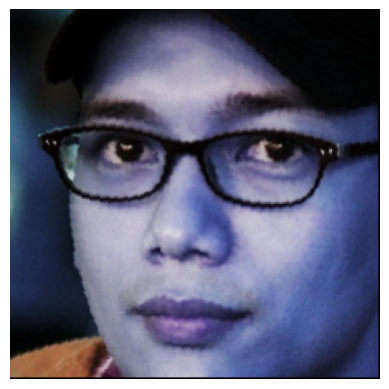

In [32]:
plt.imshow(target_img[:,:,::-1])
plt.axis('off')
plt.show()

In [33]:
target_embedding = DeepFace.represent(img_path = target_img_path, model_name = "Facenet", enforce_detection= False)[0]["embedding"]

In [39]:
bjs = DeepFace.analyze(img_path = target_img_path) 

Action: race: 100%|██████████| 4/4 [00:00<00:00,  6.25it/s]  


In [40]:
bjs

[{'emotion': {'angry': 1.3759766705334187,
   'disgust': 2.571543811225041e-08,
   'fear': 0.11458476074039936,
   'happy': 0.0018445854948367923,
   'sad': 0.5392681807279587,
   'surprise': 0.021196927991695702,
   'neutral': 97.94712662696838},
  'dominant_emotion': 'neutral',
  'region': {'x': 136,
   'y': 142,
   'w': 222,
   'h': 222,
   'left_eye': (61, 93),
   'right_eye': (151, 77)},
  'face_confidence': 0.93,
  'age': 27,
  'gender': {'Woman': 0.21611042320728302, 'Man': 99.78389143943787},
  'dominant_gender': 'Man',
  'race': {'asian': 99.4478881030016,
   'indian': 0.03864723488075941,
   'black': 0.008107787044857043,
   'white': 0.059263749320879536,
   'middle eastern': 0.0018182346313186143,
   'latino hispanic': 0.4442772627191104},
  'dominant_race': 'asian'}]

In [23]:
tic = time.time()

select_statement = "select img_name, embedding, AGE, DOMINANT_EMOTION, DOMINANT_GENDER, DOMINANT_RACE from face_meta"
results = cursor.execute(select_statement)

instances = []
for result in results:
    img_name = result[0]
    embedding_bytes = result[1]

    # Decode JSON string to Python object
    embedding_list = json.loads(result[1])
   
    # Convert the list to a NumPy array
    embedding = np.array(embedding_list, dtype=np.float32)
   
    
    instance = []
    instance.append(img_name)
    instance.append(embedding)
    instances.append(instance)

toc = time.time()
print(toc-tic,"seconds")

0.005097866058349609 seconds


In [24]:
result_df = pd.DataFrame(instances, columns = ["img_name", "embedding"])

In [25]:
my_list = [target_embedding,]

In [26]:
np.array(my_list*result_df.shape[0]).shape

(57, 128)

In [27]:
target_duplicated = np.array(my_list*result_df.shape[0])

In [28]:
result_df['target'] = target_duplicated.tolist()

In [29]:
def findEuclideanDistance(row):
    source = np.array(row['embedding'])
    target = np.array(row['target'])
    distance = (source - target)
    return np.sqrt(np.sum(np.multiply(distance, distance)))

In [30]:
tic = time.time()
result_df['distance'] = result_df.apply(findEuclideanDistance, axis = 1)
result_df = result_df[result_df['distance'] <= 10]
result_df = result_df.sort_values(by = ['distance']).reset_index(drop = True)
result_df = result_df.drop(columns = ["embedding", "target"])
toc = time.time()

print(toc-tic,"seconds")

0.005589962005615234 seconds


In [31]:
result_df.head(10)

,img_name,distance
0,../dataset/img57.jpg,1.267168


In [32]:
target_statement = ""
for i, value in enumerate(target_embedding):
    target_statement += "select %d as dimension, %s as value" % (i, str(value)) #sqlite
    #target_statement += "select %d as dimension, %s as value from dual" % (i, str(value)) #oracle
    
    if i < len(target_embedding) - 1:
        target_statement += " union all "

In [33]:
select_statement = f"""
    select * 
    from (
        select img_name, sum(subtract_dims) as distance_squared
        from (
            select img_name, (source - target) * (source - target) as subtract_dims
            from (
                select meta.img_name, emb.value as source, target.value as target
                from face_meta meta left join face_embeddings emb
                on meta.id = emb.face_id
                left join (
                    {target_statement}  
                ) target
                on emb.dimension = target.dimension
            )
        )
        group by img_name
    )
    where distance_squared < 100
    order by distance_squared asc
"""

In [34]:
tic = time.time()
results = cursor.execute(select_statement)

instances = []
for result in results:
    img_name = result[0]
    distance_squared = result[1]
    
    instance = []
    instance.append(img_name)
    instance.append(math.sqrt(distance_squared))
    instances.append(instance)

toc = time.time()
print(toc-tic,"seconds")

0.03613996505737305 seconds


In [36]:
result_df = pd.DataFrame(instances, columns = ["img_name", "distance"])

In [37]:
result_df

,img_name,distance
0,../dataset/img57.jpg,1.267168


../dataset/img57.jpg


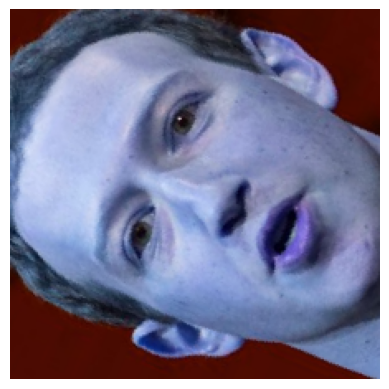

1.267167571048222
--------------------------------


In [39]:
for index, instance in result_df.iterrows():
    img_path = instance["img_name"]
    distance = instance["distance"]

    print(img_path) 
    img = DeepFace.extract_faces(img_path)[0]["face"]
    plt.imshow(img[:,:,::-1])
    plt.axis('off')
    plt.show()
    print(distance)
    print("--------------------------------")